### Transfer learning example

Data is taken from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
(You need an account for the data but Kaggle is good resource anyway)
Note the folder structure
```
train
->cat
->dog
```

(Yes I have multiple train directories)

In [1]:
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'G:/kaggle/catdog/dogs-vs-cats-redux-kernels-edition/train/train/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=12)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'G:/kaggle/catdog/dogs-vs-cats-redux-kernels-edition/train/train/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=12)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### Display Images
Because not all of the images are sqaure when we force the size to 256x256 some of them appear distorted.  This is fine. Note that the labels are infered from the folder name, but data is picked up 'at random'

['cat', 'dog']


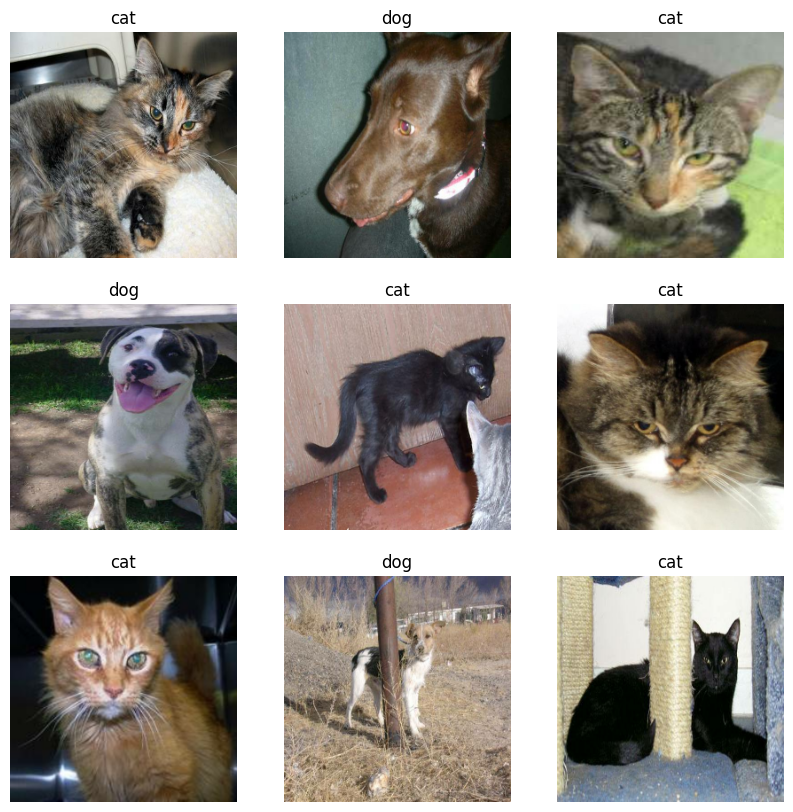

In [2]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Data Details
Most image data comes in values of 0 to 255, but of course neural networks like data between -1 and 1 or 0 and 1, so we adjust the values by divinding by the max value of 255 (including 0, thats 256 values!).  When we display the image it doesn't chaange much

Normalized Example
tf.Tensor(
[[0.5269991  0.5090993  0.50728106 0.55331653]
 [0.57555056 0.5701617  0.5642972  0.5893609 ]
 [0.59946686 0.6130362  0.611849   0.62816906]
 [0.60019916 0.6167747  0.6249924  0.6399595 ]], shape=(4, 4), dtype=float32)
Raw Example
(256, 256, 3)
tf.Tensor(
[[62.80237  64.94141  62.441406 68.135376]
 [67.292114 71.13733  70.08716  71.798584]
 [65.92554  70.28162  70.85742  68.994385]
 [69.57483  70.55078  72.911865 70.72656 ]], shape=(4, 4), dtype=float32)


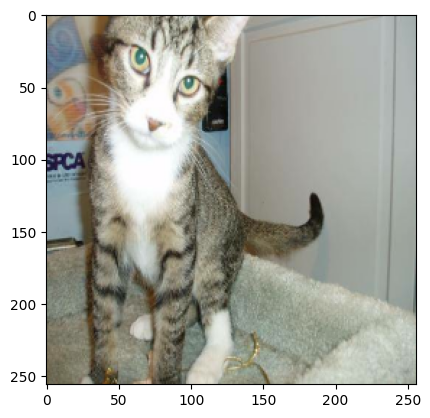

In [3]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
plt.imshow(first_image)
print('Normalized Example')
print(first_image[0:4,0:4,0])
new_batch, _ = next(iter(train_ds))
print('Raw Example')
print(new_batch[0].shape)
print(new_batch[0][0:4,0:4,0])



### Make a simple CNN from scartch

In [4]:
num_classes = 1

ex_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


In [5]:
ex_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])


In [6]:
ex_model.fit(
  train_ds,     # note in class I switched this to the normalized_ds, but since I have rescaling at line 4 in the model, I use the train_ds!     
  epochs=5,
  validation_data=val_ds
)

Epoch 1/5
1667/1667 [==============================] - 49s 27ms/step - loss: 0.6693 - accuracy: 0.5934 - val_loss: 0.6418 - val_accuracy: 0.6376
Epoch 2/5
1667/1667 [==============================] - 45s 27ms/step - loss: 0.5618 - accuracy: 0.7079 - val_loss: 0.4915 - val_accuracy: 0.7628
Epoch 3/5
1667/1667 [==============================] - 45s 27ms/step - loss: 0.4467 - accuracy: 0.7921 - val_loss: 0.4627 - val_accuracy: 0.7866
Epoch 4/5
1667/1667 [==============================] - 45s 27ms/step - loss: 0.3380 - accuracy: 0.8531 - val_loss: 0.5273 - val_accuracy: 0.7662
Epoch 5/5
1667/1667 [==============================] - 45s 27ms/step - loss: 0.2314 - accuracy: 0.9054 - val_loss: 0.5803 - val_accuracy: 0.7802


In [7]:
ex_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

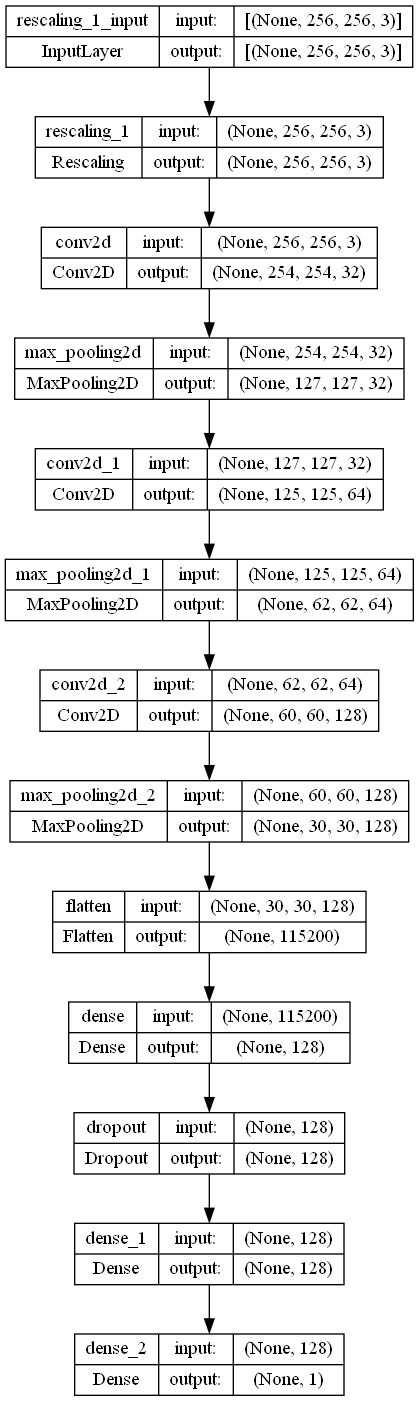

In [8]:

tf.keras.utils.plot_model(ex_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [9]:
30*30*128

115200

### Transfer Models
Not content to use our own models, lets use some famous models.  Here I use EffcientNet, but you can do the same for models like ResNet, Inception, VGG16, etc.



In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


### I will start from scractch with EfficientNetB0. 

I will not include pre-trained weights (`weights=None`) OR the final layers (`include_top=False`) before prediction.
I also 'allow' or set all of the layers to be trainable (you can pick and chose this btw).  The logs callback isn't nessecary, but nice to show what is going on.  Since I didn't include the final layers, I need to add my own.  Note that I am using the `Model()` api where I just chain together equations `x2 = GlobalAveragePooling2D()(x)` means the output is x2, and the input is x.

In [11]:
logs='arch_only'
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
es = EarlyStopping()
# create the base pre-trained model
base_model = EfficientNetB0(weights=None, include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x2 = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x3 = Dense(1024, activation='relu')(x2)
# and a logistic layer 
predictions = Dense(1, activation='sigmoid')(x3)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy','accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds,
          epochs=5,
          validation_data=val_ds,
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir = logs)])



Epoch 1/5
1667/1667 [==============================] - 217s 125ms/step - loss: 0.6391 - binary_crossentropy: 0.6391 - accuracy: 0.6405 - val_loss: 0.5955 - val_binary_crossentropy: 0.5955 - val_accuracy: 0.7142
Epoch 2/5
1667/1667 [==============================] - 205s 123ms/step - loss: 0.4911 - binary_crossentropy: 0.4911 - accuracy: 0.7678 - val_loss: 0.6300 - val_binary_crossentropy: 0.6300 - val_accuracy: 0.7168
Epoch 3/5
1667/1667 [==============================] - 205s 123ms/step - loss: 0.3739 - binary_crossentropy: 0.3739 - accuracy: 0.8354 - val_loss: 0.3294 - val_binary_crossentropy: 0.3294 - val_accuracy: 0.8606
Epoch 4/5
1667/1667 [==============================] - 205s 123ms/step - loss: 0.2930 - binary_crossentropy: 0.2930 - accuracy: 0.8781 - val_loss: 0.3003 - val_binary_crossentropy: 0.3003 - val_accuracy: 0.8666
Epoch 5/5
1667/1667 [==============================] - 206s 123ms/step - loss: 0.2381 - binary_crossentropy: 0.2381 - accuracy: 0.9034 - val_loss: 0.2195 - 

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling_2[0][0]']            
                                3)                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, None, None,   3456        ['block2a_project_bn[0][0]']     
                                144)                                                              
                                                                                                  
 block2b_e

                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   960        ['block3b_expand_conv[0][0]']    
 ization)                       240)                                                              
          

 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 block4b_expand_activation (Act  (None, None, None,   0          ['block4b_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, None, None,   1920       ['block5a_expand_conv[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 block5a_e

                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, None, None,   16800      ['block5c_expand_activation[0][0]
 D)                             672)                             ']                               
          

 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)                             1152)                            ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, None, None,   4608       ['block6b_dwconv[0][0]']         
 )        

                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6d_expand_activation[0][0]
 D)                             1152)                            ']                               
                                                                                                  
 block6d_b

                                1280)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                                  
 dense_3 (Dense)                (None, 1024)         1311744     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dense_4 (Dense)                (None, 1)            1025        ['dense_3[0][0]']                
                                                                                                  
Total para

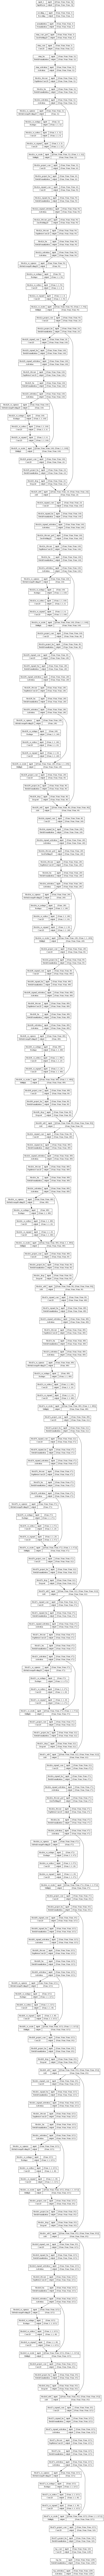

In [13]:
tf.keras.utils.plot_model(base_model, to_file='model.png', show_shapes=True, show_layer_names=True)

### Transfer Learning
Now I will download the previously trained weights.  Notice I now use `weights='imagenet'` and set the base model to not be trainable with `layer.trainable = False`.  Even though I am freezing 99% of the network, I am allowsing my dense layer to recombine the features.  Look at how quickly this network acheives a super-high result. Also note that the network trains 5X faster (on my machine) since we are only training the last few layers!

USE TRANSFER LEARNING!

In [14]:
logs='transfer_example'
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
es = EarlyStopping()
base_model = EfficientNetB0(weights='imagenet', include_top=False)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# add a global spatial average pooling layer
x = base_model.output
x2 = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x3 = Dense(1024, activation='relu')(x2)
# and a logistic layer 
predictions = Dense(1, activation='sigmoid')(x3)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy','accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds,
          epochs=1,
          validation_data=val_ds,
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir = logs)])


1667/1667 [==============================] - 80s 45ms/step - loss: 0.0310 - binary_crossentropy: 0.0310 - accuracy: 0.9894 - val_loss: 0.0200 - val_binary_crossentropy: 0.0200 - val_accuracy: 0.9928


In [15]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                          

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 1280)        0           ['top_activation[0][0]']         
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_5 (Dense)                (None, 1024)         1311744     ['global_average_pooling2d_1[0][0
                                                                 ]']                              
          

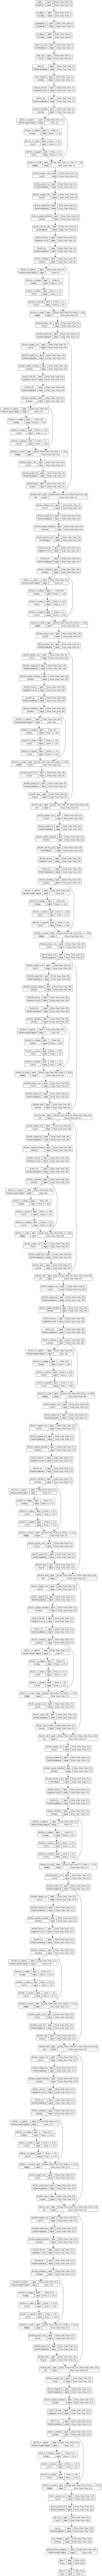

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

 You can see that the transfer learning was faster and more accurate than training from scratch, as well as much faster and more accurate than my 'basic' model.  1 epoch of Effcientnet took almost 5 minutes to train, while transfer learning with it, took 1.5 minutes per epoch and we ended with 99% accuracy after only 1 epoch!!  This was not even close to where we were after 5 epochs of our own!  Effcientnet is also one of the best performing (and largest--it is designed for scaling) networks!  So we can get to use an advanced network with just a few lines of code.

In [ ]:
import pandas as pd
data = pd.read_csv("G:/cs6/all_train.csv", nrows=10000)

In [18]:
data